In [1]:
import numpy as np
import nibabel as nb
import sys
import os
import yaml
import matplotlib.pyplot as plt
import gurobipy as gp
%matplotlib widget 
from mpl_toolkits.mplot3d import Axes3D
sys.path.append("/home/mehdii/projects/def-vidalthi/mehdii/3DPU_Plateau_Problem")
from src.PU3D_project._3DLoops._3dpu_using_dfs import *
from src.PU3D_project.Block_edges.block_edges import *
import src.PU3D_project.ROMEO.romeo.utils as romeo
import src.PU3D_project.MIP_constraints.Python as MIP
import src.PU3D_project.utils as utils

## Create a data set or extract it

### Extract the data

In [2]:
config = yaml.safe_load(open("/home/mehdii/projects/def-vidalthi/mehdii/3DPU_Plateau_Problem/paths.yaml"))

In [3]:
path_data = config["paths"]["phase_data"]
data_brut = nb.load(path_data)
t = 1
phase = data_brut.get_fdata()[:,:,:20,t]

In [4]:
phase.shape

(208, 208, 20)

Text(0.5, 1.0, 'Wrapped Phase for z = 20')

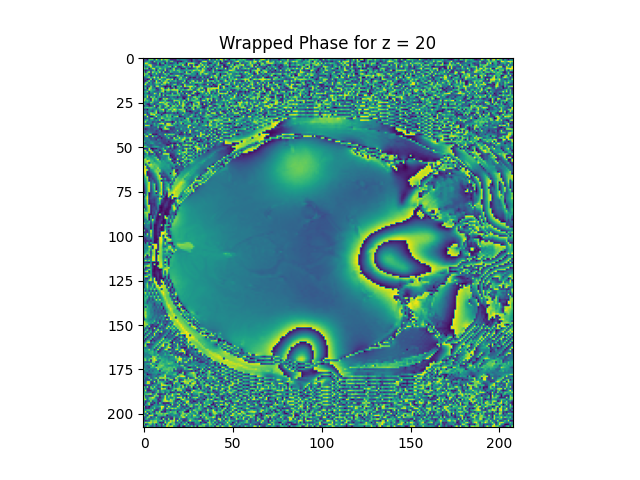

In [5]:
fig = plt.figure()
plt.imshow(phase[:,:,-3])
plt.title("Wrapped Phase for z = 20")

### Create the data

In [2]:
import numpy as np

def generate_noisy_phase(x_dim=101, y_dim=101, z_dim=51, height=5, noise_mean=0, noise_sd=10):
    # Create grid
    x = np.linspace(0, x_dim-1, x_dim)
    y = np.linspace(0, y_dim-1, y_dim)
    z = np.linspace(0, z_dim-1, z_dim)
    x, y, z = np.meshgrid(x, y, z, indexing='ij')

    # Compute phase values
    phi = height * ((np.sin(x) / np.pi) * (150 - z) + (np.sin(y) / np.pi) * (49 + z))

    # Add Gaussian noise
    noise = np.random.normal(noise_mean, noise_sd, phi.shape)
    phi_noisy = phi + noise

    return phi_noisy


def generate_phase_volume(frame_size=256, num_frames=100, noise_start_frame=47, noise_end_frame=62, noise_mean=0, noise_std=1.55):
    original_phase_volume = np.zeros((frame_size, frame_size, num_frames))
    
    def sigma1(t):
        return 1.50 - (0.01 * (t + 1))

    def sigma2(t):
        return 0.49 + (0.01 * (t + 1))
    
    for t in range(num_frames):
        for i in range(frame_size):
            for j in range(frame_size):
                x = (i - (frame_size / 2)) / (frame_size / 2) * np.pi
                y = (j - (frame_size / 2)) / (frame_size / 2) * np.pi
                original_phase_volume[i, j, t] = 10 * (sigma1(t) * (np.sin(x) / x if x != 0 else 1) + sigma2(t) * (np.sin(y) / y if y != 0 else 1))
    
    noisy_region = np.random.normal(noise_mean, noise_std, (frame_size, frame_size, noise_end_frame - noise_start_frame + 1))
    original_phase_volume[:, :, noise_start_frame:noise_end_frame + 1] += noisy_region
    
    wrapped_phase_volume = np.mod(original_phase_volume + np.pi, 2 * np.pi) - np.pi
    
    return original_phase_volume, wrapped_phase_volume

In [18]:
original_phase_volume, wrapped_phase_volume = generate_phase_volume(frame_size=64, num_frames=25, noise_start_frame=12, noise_end_frame=17, noise_mean=0, noise_std=1.55)
fig = plt.figure()
plt.imshow(wrapped_phase_volume[:, :, 8], cmap='jet')


NameError: name 'generate_phase_volume' is not defined

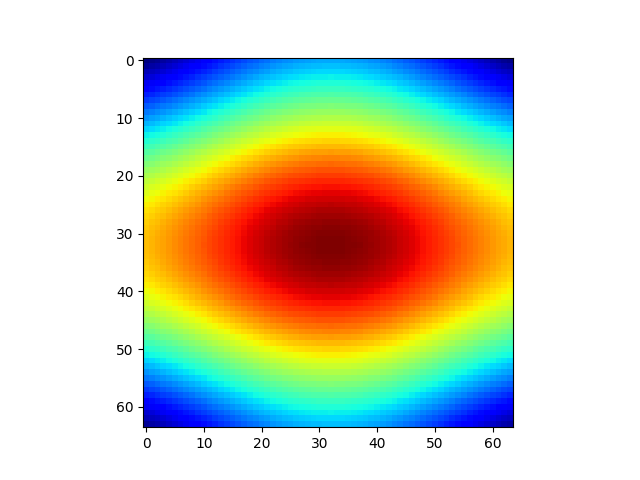

In [4]:
fig = plt.figure()
plt.imshow(original_phase_volume[:, :, 8], cmap='jet')

### Detect the loops

In [5]:
from src.PU3D_project.MIP_constraints.Python.CleanCycles import *
from gurobipy import *

def minimize_edges_MIP(Edges, num_threads=1):
    Marked_edges = []
    Blocked_edges = Edges
    G = GraphGrid3D(Blocked_edges, [])

    # Create a new model
    model = Model("Graph Problem")

    # Suppress Gurobi solver output
    model.setParam('OutputFlag', 0)
    model.setParam('Threads', num_threads)

    # Define the decision variables
    x = model.addVars(G.edges, vtype=GRB.BINARY, name="x")

    # Define the objective function
    model.setObjective(quicksum(x[i] for i in G.edges), GRB.MINIMIZE)

    # Initialize Graph_Cycles object
    GC = Graph_Cycles(Blocked_edges, Marked_edges)

    # Function to update the marked edges based on the current solution
    def update_marked_edges():
        new_marked = []
        for edge in G.edges:
            if x[edge].X > 0.5:
                new_marked.append([G.mapping[edge[0]], G.mapping[edge[1]]])
        return new_marked

    # Add the initial constraint from GC.b_1
    if GC.b_1:
        initial_cycle = min(GC.b_1, key=len)
        initial_cycle_edges = [(min(initial_cycle[i], initial_cycle[i + 1]), max(initial_cycle[i], initial_cycle[i + 1])) for i in range(len(initial_cycle) - 1)]
        model.addConstr(quicksum(x[edge] for edge in initial_cycle_edges) >= 1)

    # Optimize the model with the initial constraint
    model.optimize()

    # Main loop: update cycles and add new constraints until GC.b_1 is empty
    while GC.b_1:
        
        # Update marked edges and GC.b_1 based on the current solution
        Marked_edges = update_marked_edges()

        GC = Graph_Cycles(Blocked_edges, Marked_edges)

        # If no more cycles, break the loop
        if not GC.b_1:
            break

        # Add the smallest cycle constraint from GC.b_1
        smallest_cycle = min(GC.b_1, key=len)
        smallest_cycle_edges = [(min(smallest_cycle[i], smallest_cycle[i + 1]), max(smallest_cycle[i], smallest_cycle[i + 1])) for i in range(len(smallest_cycle) - 1)]
        model.addConstr(quicksum(x[edge] for edge in smallest_cycle_edges) >= 1)
        new_constr = None
        non_null_edges = []

        # Reset and optimize the model again
        model.reset()
        model.optimize()

    if model.status != GRB.OPTIMAL:
        print("No optimal solution found.")

    return Marked_edges


In [6]:
with open('Blocked_edges_cycles_init.pkl', 'rb') as f:
    Blocked_edges_cycles_init = pickle.load(f)
with open('Blocked_edges_open_paths_init.pkl', 'rb') as f:
    Blocked_edges_open_paths_init = pickle.load(f)

## Use our Method on it

*Detect the loops*

In [4]:
C = Resiuals(phase)
C.create_loops(separate = False)

In [5]:
test_loop = [cyc for cyc in C.cycles if len(cyc) > 10][0]
len(test_loop)
Edges,M = MIP.fill_cycle(test_loop,C)
# Minimized_Edges = MIP.minimize_edges_MIP(Edges, num_threads=4)

In [6]:
GC = MIP.Graph_Cycles(Edges, [])
dict_nodes, dict_edges, edges = GC.spanning_tree_BFS()

In [8]:
def spanning_tree_BFS(self):
    dict_nodes = {}
    dict_passage = {}
    visited = set()
    edges = set()

    for node in range(len(self.mapping_GC)):
        dict_nodes[node] = 0
    
    for edge in self.edges:
        dict_passage[node] = None
    
    start_node = np.random.randint(0,len(self.mapping_GC))
    deque_nodes = deque([start_node])
    visited.add(start_node)

    while deque_nodes:
        node = deque_nodes.popleft()
        for neighbor in self.Graph[node]:
            if neighbor not in visited:
                visited.add(neighbor)
                edge = (min(node,neighbor),max(node,neighbor))
                edges.add(edge)
                dict_passage[neighbor] = node
                if edge in self.blocked_edges:
                    dict_nodes[neighbor] = dict_nodes[node] + 1
                    
                deque_nodes.append(neighbor)
    
    return dict_nodes,dict_passage,edges

{124: None, 57: 62}

### Fill in the loops

In [11]:
List_M = []
for cycle in tqdm(C.cycles):
    cycle = [utils.transform_res_to_point(C.mapping[i]) for i in cycle]
    boundary = PointList()
    boundary.points = cycle
    numberçof_triangles = min(10,3*len(cycle))
    M = Final_minimization(boundary,10*len(cycle))
    M.create_quadrilaterals()
    M.split_quadrilateral()
    M.canonic_representation_from_mesh()
    M.clean_triangles()
    M.fill_edges()
    M.update_weights()
    
    # epsilon = 0.01
    # area = M.calculate_area()
    for i in (M.inside_indexes):
        M.update_mapping(i)
    for i in (M.inside_indexes):
        M.mapping[i] = M.mapping[i] + np.random.normal(1,0.3,3)
    length = min(10,len(cycle))
    for _ in (range(length)):
        M.lawson_flip()
        area = M.calculate_area()
        M.update_weights()
        for i in (M.inside_indexes):
            M.update_mapping(i)
    List_M.append(M)
with open("Data_MRI_0_125/List_M.pkl", "wb") as f:
    pickle.dump(List_M, f)


 11%|█         | 1737/16042 [04:50<36:29,  6.53it/s]  /home/mehdii/projects/def-vidalthi/mehdii/3DPU_Plateau_Problem/src/PU3D_project/Plateau_Problem/Triangulation_Meshing/Flairing_Laplace.py:59: RuntimeWarning: invalid value encountered in scalar divide
  self.w[i,j] =  S_ij / S
100%|██████████| 16042/16042 [32:35<00:00,  8.20it/s]  


: 

In [6]:
with open("Data_MRI_0_125/List_M.pkl", "rb") as f:
    List_M = pickle.load(f)

EOFError: Ran out of input

In [5]:
List_M

NameError: name 'List_M' is not defined

In [6]:
Blocked_edges_cycles_init = []
for M in tqdm(List_M):
    B = Block_edges(M.triangles,M.mapping)
    B.block_all_the_edges()
    Blocked_edges_cycles_init.append(B.blocked_edges)

NameError: name 'List_M' is not defined

In [12]:
List_M_open_paths = []
for cycle in tqdm(C.open_paths):
    boundary = PointList()
    boundary.points = cycle
    M = Final_minimization(boundary,5*len(cycle))
    M.create_quadrilaterals()
    M.split_quadrilateral()
    M.canonic_representation_from_mesh()
    M.clean_triangles()
    M.fill_edges()
    M.update_weights()
    epsilon = 0.01
    area = M.calculate_area()
    for i in (M.inside_indexes):
        M.update_mapping(i)
    
    for _ in range(20):
        M.lawson_flip()
        area = M.calculate_area()
        M.update_weights()
        for i in (M.inside_indexes):
            M.update_mapping(i)
    List_M_open_paths.append(M)

100%|██████████| 298/298 [00:23<00:00, 12.85it/s]


In [13]:
Blocked_edges_open_paths_init = []
for M in tqdm(List_M_open_paths):
    B = Block_edges(M.triangles,M.mapping)
    B.block_all_the_edges()
    Blocked_edges_open_paths_init.append(B.blocked_edges)

100%|██████████| 298/298 [00:42<00:00,  7.02it/s]


In [23]:
# with open('List_M_cycle.pkl',"wb") as f:
#     pickle.dump(List_M,f)
# with open('List_M_open_paths.pkl',"wb") as f:
#     pickle.dump(List_M_open_paths,f)

In [14]:
len(max(Blocked_edges_cycles_init,key = len)),len(max(Blocked_edges_open_paths_init,key = len))

(89, 136)

In [16]:
with open("Blocked_edges_open_paths_init.pkl", "wb") as f:
    pickle.dump(Blocked_edges_open_paths_init, f)

In [76]:
MIP_blocked_edges_open_paths = []
for blcked_edges in tqdm(Blocked_edges_open_paths_init):
    try:
        MIP_blocked_edges_open_paths.append(minimize_edges_MIP(blcked_edges,num_threads = 10))
    except gp.GurobiError as e:
        MIP_blocked_edges_open_paths.append(blcked_edges)
        print(f'GurobiError: {e}')
        continue

100%|██████████| 298/298 [03:25<00:00,  1.45it/s]


In [23]:
New_mixed_edges = MIP_blocked_edges + Blocked_edges_cycles_init[1232:]
len(New_mixed_edges),len(Blocked_edges_cycles_init)

(3370, 3370)

In [53]:
Center = np.mean(np.array([]))

IndexError: list index out of range

## Drawing

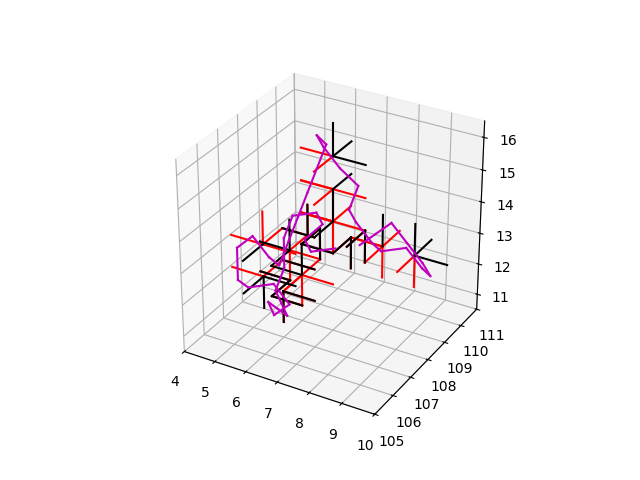

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')



X = []
Y = []
Z = []

cycle = test_loop

for edge in Edges:
    ax.plot([edge[0][0],edge[1][0]],[edge[0][1],edge[1][1]],[edge[0][2],edge[1][2]],color = 'r')

for edge in Minimized_Edges:
    ax.plot([edge[0][0],edge[1][0]],[edge[0][1],edge[1][1]],[edge[0][2],edge[1][2]],color = 'black')


colour = np.random.choice(['r','g','b','y','c','m','k'])
for i in range(len(cycle) - 1): 
    p1 = utils.transform_res_to_point(C.mapping[cycle[i]])
    p2 = utils.transform_res_to_point(C.mapping[cycle[i + 1]])
    ax.plot([p1[0],p2[0]],[p1[1],p2[1]],[p1[2],p2[2]],color = colour)
    X.append(p1[0])
    Y.append(p1[1])
    Z.append(p1[2])
    X.append(p2[0])
    Y.append(p2[1])
    Z.append(p2[2])

X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)

max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0 

mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

plt.show()



In [36]:
longest_cycle = max(C.cycles, key=len)
ind_longest_cycle = C.cycles.index(longest_cycle)
longest_cycle = [utils.transform_res_to_point(C.mapping[i]) for i in longest_cycle]
cycle = longest_cycle
M_longest_cycle = List_M[ind_longest_cycle]
M = M_longest_cycle
for _ in tqdm(range(100)):
    M.lawson_flip()
    area = M.calculate_area()
    M.update_weights()
    for i in (M.inside_indexes):
        M.update_mapping(i)
M.mapping = [np.array(m) for m in M.mapping]


100%|██████████| 1539/1539 [00:00<00:00, 51418.14it/s]

1655it [00:00, 45049.12it/s]            

1576it [00:00, 50441.62it/s]            

1551it [00:00, 51902.17it/s]            

1541it [00:00, 52642.31it/s]            

1540it [00:00, 53433.28it/s]            

  2%|▏         | 2/100 [00:00<00:14,  6.86it/s]
1620it [00:00, 48039.96it/s]            

1558it [00:00, 51988.33it/s]            

1541it [00:00, 52993.64it/s]            

  3%|▎         | 3/100 [00:00<00:14,  6.57it/s]
1577it [00:00, 50458.61it/s]            

1544it [00:00, 53654.18it/s]            

1540it [00:00, 53858.32it/s]            

  4%|▍         | 4/100 [00:00<00:14,  6.52it/s]
1567it [00:00, 51344.25it/s]            

1540it [00:00, 53713.66it/s]            

  5%|▌         | 5/100 [00:00<00:13,  6.97it/s]
1572it [00:00, 51957.81it/s]            

1541it [00:00, 53398.18it/s]            

  6%|▌         | 6/100 [00:00<00:12,  7.26it/s]
1557it [00:00, 52638.41it/s]            

100%|██████████| 1539/1539 [00:0

## Use Romeo on it

In [180]:
Edges_open_paths = []
Edges_cycles = []
for edges in New_mixed_edges:
    Edges_cycles.extend(edges)
for edges in Blocked_edges_open_paths_init:
    Edges_open_paths.extend(edges)
Edges_cycles = [(tuple(edge[0]),tuple(edge[1])) for edge in Edges_cycles]
Edges_open_paths = [(tuple(edge[0]),tuple(edge[1])) for edge in Edges_open_paths]
len(Edges_cycles),len(Edges_open_paths)

(11184, 11869)

In [193]:
def unwrapp(phase,Edges):
    All_nodes = set([(i,j,k) for i in range(phase.shape[0]) for j in range(phase.shape[1]) for k in range(phase.shape[2])])
    Visited = set()
    Unvisited = All_nodes - Visited
    Blocked_Edges = set(Edges)
    Unwrapped_phase = np.zeros(phase.shape)
    directions = [(1,0,0),(-1,0,0),(0,1,0),(0,-1,0),(0,0,1),(0,0,-1)]
    while Unvisited:
        print(len(Unvisited))
        source = list(Unvisited)[np.random.randint(len(Unvisited))]
        Unvisited.remove(source)
        Unwrapped_phase[source] = phase[source]
        layer = set([source])
        while layer:
            next_layer = set()
            for node in layer:
                Visited.add(node)
                for direction in directions:
                    new_node = tuple(np.array(node)+np.array(direction))
                    if new_node in All_nodes and new_node not in Visited:
                        if (node,new_node) not in Blocked_Edges and (new_node,node) not in Blocked_Edges:
                            Unwrapped_phase[new_node] = unwrapp_function(Unwrapped_phase[node],phase[new_node])
                            next_layer.add(new_node)
            layer = next_layer
        Unvisited = All_nodes - Visited
    return Unwrapped_phase,Visited

In [270]:
# unwrapp_us,Unvisited = unwrapp(wrapped_phase_volume,Edges_cycles)
N_us = utils.compute_absolute_phase_gradients(unwrapp_scikit,original_phase_volume)
print(N_us)

93525


Text(0.5, 1.0, 'Unwrapped phase using scikit.unwrap pour z = 20')

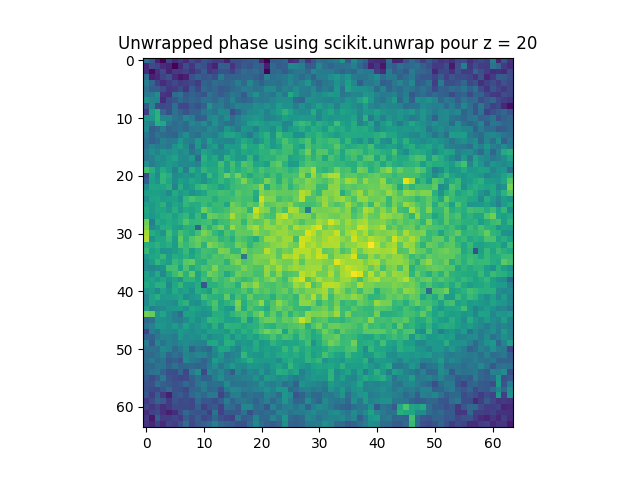

In [259]:
fig = plt.figure()
plt.imshow(unwrapp_us[:,:,20])
plt.title("Unwrapped phase using scikit.unwrap pour z = 20")

Text(0.5, 1.0, 'Wrapped Phase for z = 20')

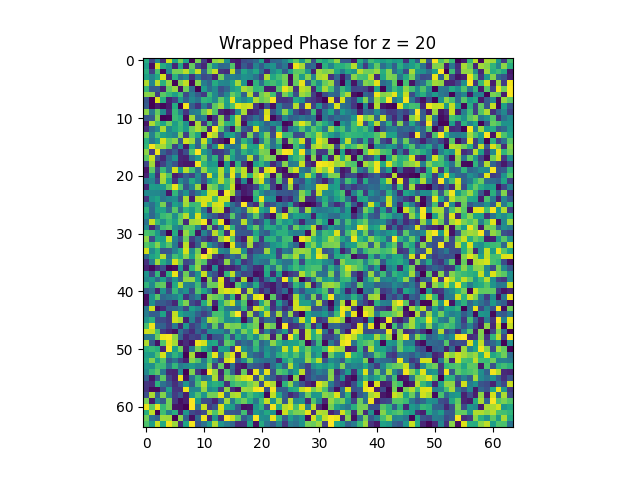

In [265]:
fig = plt.figure()
plt.imshow(wrapped_phase_volume[:,:,20])
plt.title("Wrapped Phase for z = 20")

In [13]:
# unwrapp_us,Unvisited = unwrapp(cut_phase,[])
N_us = utils.compute_absolute_phase_gradients(unwrapp_us,cut_phase)
# Special_edges = []
# for edge in Edges_open_paths + Edges_cycles:
#     if edge[0] in Unvisited or edge[1] in Unvisited:
#         Special_edges.append(edge)

N_us

533246

In [160]:
Leftover_edges = set(Edges_cycles+Edges_open_paths).difference(set(Special_edges))
len(Leftover_edges),len(Special_edges)


(13121, 5605)

In [242]:

completely_block = False
forbidden_edges_cycles = Edges_cycles
forbidden_edges_open_paths = Edges_open_paths
weight_open_paths = 400
quality_map_ = romeo.quality_map(wrapped_phase_volume)
cost_map = romeo.quality_to_cost(quality_map_)
if completely_block:
    unwrapped_phase = romeo.phase_unwrapping(cost_map, wrapped_phase_volume, [])  
else:
    for edge in Special_edges:
        cost_map[edge] = weight_open_paths
    unwrapped_phase = romeo.phase_unwrapping(cost_map, wrapped_phase_volume,Leftover_edges)
N_romeo = utils.compute_absolute_phase_gradients(unwrapped_phase,wrapped_phase_volume)
N_romeo


100%|██████████| 299904/299904 [00:00<00:00, 632320.23it/s]


36995

In [150]:
GR = nx.Graph()
x_max,y_max,z_max = wrapped_phase_volume.shape
for i in range(x_max):
    for j in range(y_max):
        for k in range(z_max):
            GR.add_edge((i,j,k),(i+1,j,k))
            GR.add_edge((i,j,k),(i,j+1,k))
            GR.add_edge((i,j,k),(i,j,k+1))
            GR.add_edge((i,j,k),(i-1,j,k))
            GR.add_edge((i,j,k),(i,j-1,k))
            GR.add_edge((i,j,k),(i,j,k-1))

Nodes = list(GR.nodes)
for node in Nodes:
    if node[0] == -1 or node[0] == x_max or node[1] == -1 or node[1] == y_max or node[2] == -1 or node[2] == z_max:
        GR.remove_node(node)

for edge in set(Edges_cycles):
    if (edge[0],edge[1]) in GR.edges:
        GR.remove_edge(edge[0],edge[1])
    else:
        GR.remove_edge(edge[1],edge[0])

CC = (list(nx.connected_components(GR)))
print(len(CC))


31


In [168]:
len(CC)

31

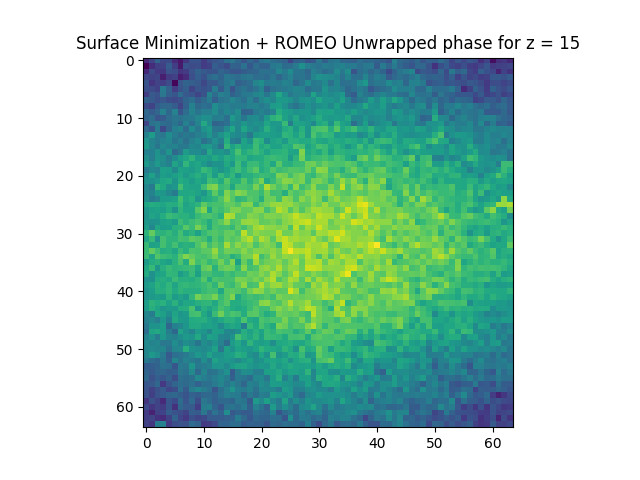

In [134]:
fig = plt.figure()
plt.imshow(unwrapped_phase[:,:,15])
plt.title("Surface Minimization + ROMEO Unwrapped phase for z = 15")
plt.show()

In [133]:
plt.close()

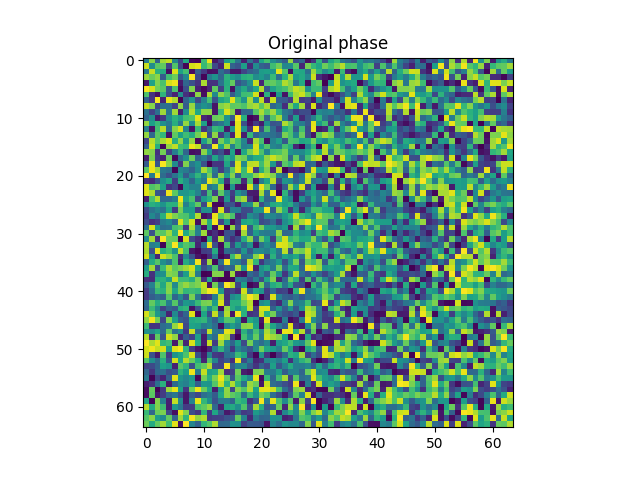

In [69]:
fig = plt.figure()
plt.imshow(wrapped_phase_volume[:,:,15])
plt.title("Original phase")
plt.show()

In [145]:
unwrapp_bad,Visited = unwrapp(phase,[])
N_bad = utils.compute_absolute_phase_gradients(unwrapp_bad,phase)
# print(phase.size - len(Visited),N_us)
print(N_bad)

156336


In [74]:
unwrapp_empty,Visited = unwrapp(phase,[])
N_empty = utils.compute_absolute_phase_gradients(unwrapp_empty,phase)
print(phase.size - len(Visited),N_empty)

0 156336


In [71]:
with open("Abdel_Rahman_experience/original_phase_volume.pkl", "wb") as f:
    pickle.dump(original_phase_volume, f)
with open("Abdel_Rahman_experience/wrapped_phase_volume.pkl", "wb") as f:
    pickle.dump(wrapped_phase_volume, f)

with open("Abdel_Rahman_experience/List_M_open_paths.pkl", "wb") as f:
    pickle.dump(List_M_open_paths, f)
with open("Abdel_Rahman_experience/List_M.pkl", "wb") as f:
    pickle.dump(List_M, f)

with open("Abdel_Rahman_experience/Blocked_edges_open_paths_init.pkl", "wb") as f:
    pickle.dump(Blocked_edges_open_paths_init, f)
with open("Abdel_Rahman_experience/Blocked_edges_cycles_init.pkl", "wb") as f:
    pickle.dump(Blocked_edges_cycles_init, f)

with open("Abdel_Rahman_experience/MIP_blocked_edges.pkl", "wb") as f:
    pickle.dump(MIP_blocked_edges, f)
with open("Abdel_Rahman_experience/New_mixed_edges.pkl", "wb") as f:
    pickle.dump(New_mixed_edges, f)

## Scikit learn usage

In [15]:
from skimage.restoration import unwrap_phase

In [16]:
unwrapp_scikit = unwrap_phase(cut_phase)
N_scikit = utils.compute_absolute_phase_gradients(cut_phase,unwrapp_scikit)
N_scikit

363126

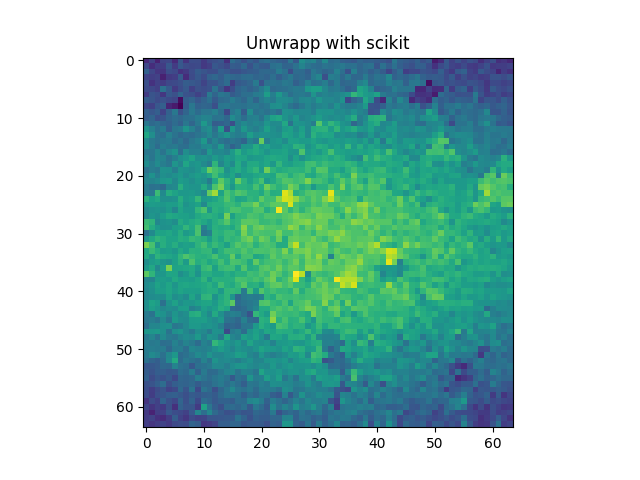

In [63]:
fig = plt.figure()
plt.imshow(unwrapp_scikit[:,:,15])
plt.title("Unwrapp with scikit")
plt.show()

## Link the open paths

In [76]:
out_frame = nx.Graph()
X_,Y_,Z_ = 10,10,15

for i in range(X_):
    for j in range(Y_):
        out_frame.add_edge((i,j+1,0),(i,j,0))
        out_frame.add_edge((i+1,j,0),(i,j,0))
        out_frame.add_edge((i,j+1,Z_-1),(i,j,Z_-1))
        out_frame.add_edge((i+1,j,Z_-1),(i,j,Z_-1))




for j in range(Y_):
    for k in range(Z_):
        out_frame.add_edge((0,j,k),(0,j,k+1))
        out_frame.add_edge((X_-1,j,k),(X_-1,j+1,k))
        out_frame.add_edge((0,j,k),(0,j+1,k))
        out_frame.add_edge((X_-1,j,k),(X_-1,j,k+1))

for i in range(X_): 
    for k in range(Z_):
        out_frame.add_edge((i,0,k),(i,0,k+1))
        out_frame.add_edge((i,0,k),(i+1,0,k))
        out_frame.add_edge((i,Y_-1,k),(i+1,Y_-1,k))
        out_frame.add_edge((i,Y_-1,k),(i,Y_-1,k+1))

Nodes = list(out_frame.nodes)
for node in Nodes:
    if node[0] == X_ or node[1] == Y_ or node[2] == Z_:
        out_frame.remove_node(node)





In [78]:

degree_4 = [node for node in out_frame.nodes() if out_frame.degree(node) == 4]
degree_1 = [node for node in out_frame.nodes() if out_frame.degree(node) == 1]
degree_2 = [node for node in out_frame.nodes() if out_frame.degree(node) == 2]
degree_3 = [node for node in out_frame.nodes() if out_frame.degree(node) == 3]

len(degree_1),len(degree_2),len(degree_3),len(degree_4)


(0, 0, 8, 660)

In [84]:
utils.transform_res_to_point(C.mapping[C.open_paths[0][0]])


(1.5, 21.5, 6)

In [12]:
utils.transform_res_to_point(C.mapping[C.open_paths[12][0]])

(12.5, 35.5, 19)

In [93]:
C.open_paths[0].index(28306)

51

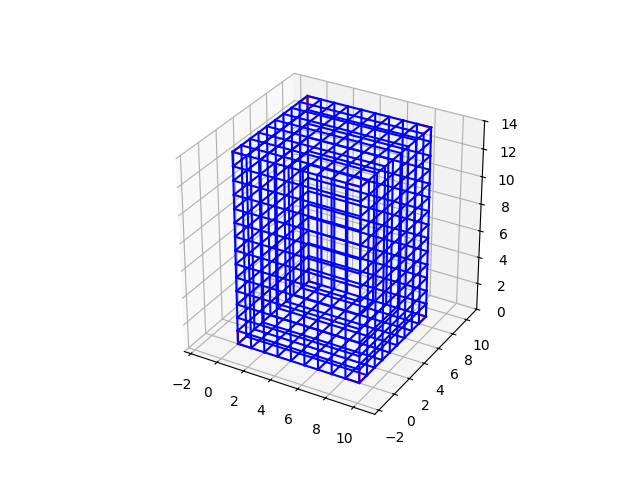

In [77]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')

X = []
Y = []
Z = []

for edge in out_frame.edges:
    edgeX = [edge[0][0], edge[1][0]]
    edgeY = [edge[0][1], edge[1][1]]
    edgeZ = [edge[0][2], edge[1][2]]
    if out_frame.degree(edge[0]) == 3 or out_frame.degree(edge[1]) == 3:
        ax.plot(edgeX, edgeY, edgeZ, color='r')
    ax.plot(edgeX, edgeY, edgeZ, color='b')
    X.extend(edgeX)
    Y.extend(edgeY)
    Z.extend(edgeZ)

    



X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)

max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0 

mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

plt.show()

